In [28]:
# Import libraries
# Libraries for data inspection
import pandas as pd
import numpy as np
import seaborn as sns
from spicy import stats
from matplotlib import pyplot as plt
from sqlalchemy import delete
import matplotlib
%matplotlib inline

# Libraries for model training
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso

# Libraries for GridSearch 
from sklearn.tree import DecisionTreeRegressor

In [2]:
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [3]:
# Import the dataset
original_df = pd.read_csv("Homes for Sale and Real Estate.csv")
original_df.head()

,Address,Price,Description,Place,Beds,Bath,Sq.Ft,Website
0,3704 42 St SW,979999,CA AB T3E 3N1,Glenbrook,4,3.5,1813,Century 21 Bravo Realty
1,30 Mahogany Mews SE #415,439900,CA AB T3M 3H4,Mahogany,2,2.0,1029,Century 21 Bamber Realty Ltd.
2,273 Auburn Shores Way SE,950000,CA AB T3M 2E9,Auburn Bay,4,2.5,2545,Exp Realty
3,235 15 Ave SW #404,280000,CA AB T2R 0P6,Beltline,2,2.0,898,RE/MAX Realty Professionals
4,24 Hemlock Crescent SW #2308,649000,CA AB T3C 2Z1,Spruce Cliff,2,2.0,1482,Charles


In [4]:
original_df.describe()

,Price,Beds,Bath,Sq.Ft
count,3.360000e+03,3360.000000,3360.000000,3360.000000
mean,7.500648e+05,3.125000,2.479167,1558.815179
std,6.447619e+05,1.349087,1.023546,1056.424307
min,1.419000e+05,1.000000,1.000000,307.000000
25%,3.990000e+05,2.000000,2.000000,933.000000
50%,6.199000e+05,3.000000,2.500000,1352.000000
75%,8.499220e+05,4.000000,3.500000,2023.250000
max,1.000000e+07,10.000000,8.000000,39654.000000


In [5]:
# Drop unused data
df = original_df.drop(['Address', 'Description', 'Website'], axis = 'columns')

In [6]:
# Inspect the dataset size
df.shape 
# The dataset has 3360 rows and 5 columns

(3360, 5)

In [7]:
# Check for null data. Drop null data
df.isnull().sum()
df = df.dropna()

In [8]:
df.shape

(3344, 5)

In [9]:
# Group data by place
location_pts = df.groupby('Place')['Place'].agg('count').sort_values(ascending = False)
location_pts
# There are 308 unique towns

Place
Beltline                     155
Saddle Ridge                  72
Legacy                        60
Mahogany                      56
Cranston                      54
                            ... 
Fresco Gardens - Taradale      1
Riverside Gate                 1
Georgian Village               1
Rideau Park                    1
Zen In Aspen                   1
Name: Place, Length: 308, dtype: int64

In [10]:
# Number of location with less than 20 datapoints
len(location_pts[location_pts <= 20])

260

In [11]:
# Group data by number of beds in the house
df.groupby('Beds')['Beds'].agg('count')
# The dataset has the house number range from 1 to 10. Houses with 2 beds have the most count, then come to 4-bed and 3-bed. Houses with 10-bed has the least count (1)

Beds
1     363
2     852
3     814
4     838
5     331
6     113
7      24
8       8
10      1
Name: Beds, dtype: int64

In [12]:
df['Beds'].describe()

count    3344.000000
mean        3.120813
std         1.347180
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Beds, dtype: float64

<Axes: xlabel='Beds', ylabel='count'>

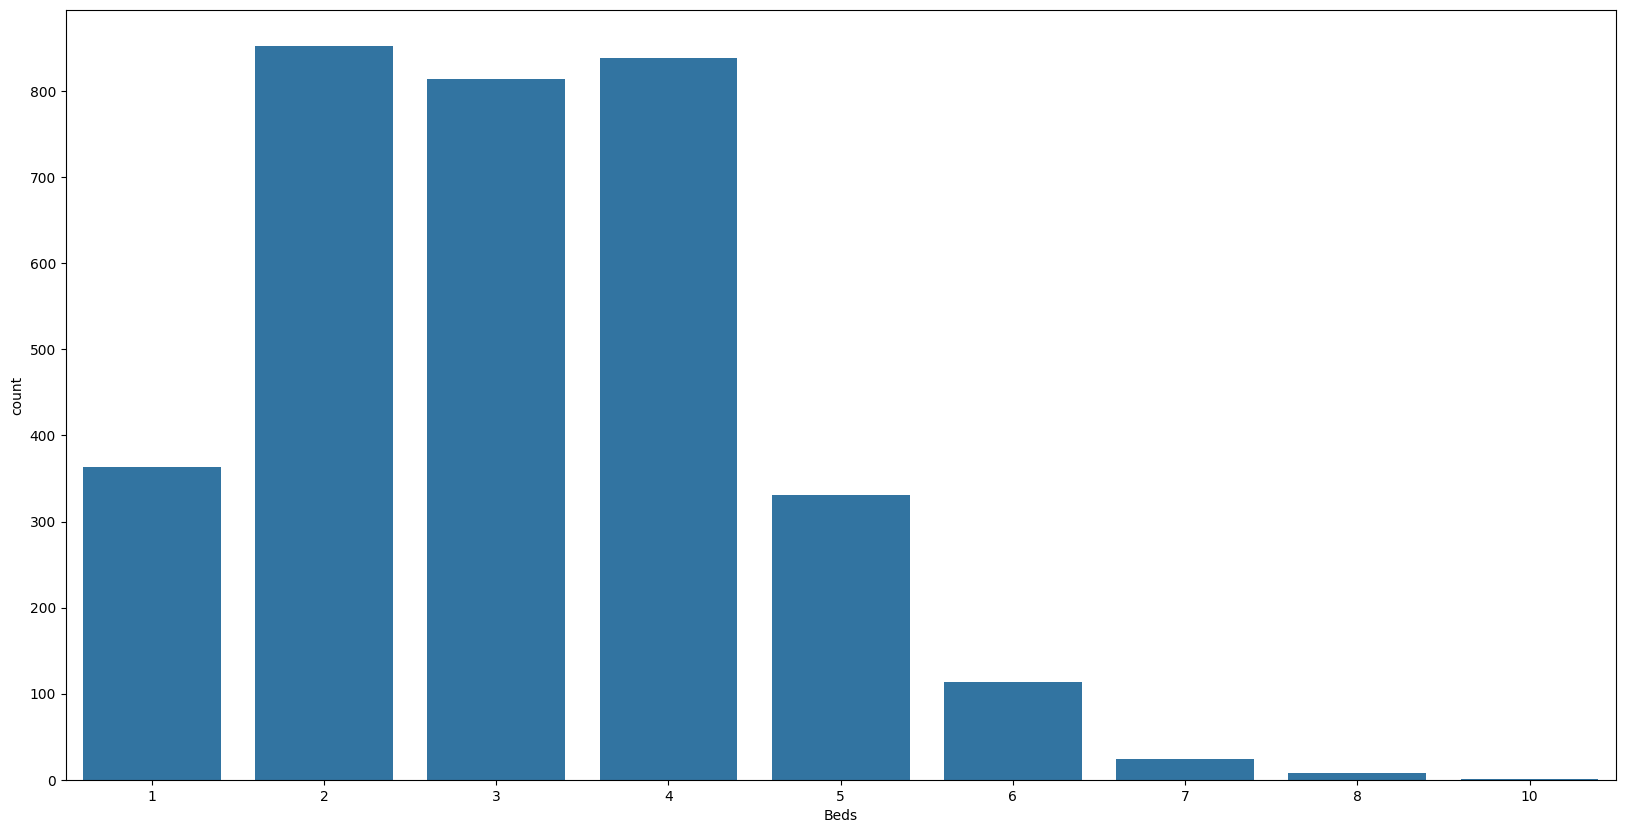

In [13]:
# Plot the dataset aggregated by number of beds
sns.countplot(x = df['Beds'])

In [14]:
# Detect outlier in the dataset
# Calculate z-score
z = np.abs(stats.zscore(df['Beds']))

# Print out outliers
print("Outliers: ", df[z > 3])

# The outliers are the houses with 8 and 10 beds

Outliers:          Price                 Place  Beds  Bath  Sq.Ft
405   1290000        West Hillhurst     8   4.0   2505
718   1200000  Bridgeland/Riverside     8   4.0   1988
1830   880000               Bowness    10   4.0   2054
2162   949800       Mayland Heights     8   4.0   2201
2230   934999          Saddle Ridge     8   6.0   2737
2646   998690         Highland Park     8   4.0   1645
2683  3700000       Springbank Hill     8   7.5   8179
3000  1265000          Saddle Ridge     8   6.0   3264
3194  1799000          Capitol Hill     8   8.0   2962


In [15]:
# Delete the outlier rows for bedroom number
outliers = df[(df['Beds'] == 8) | (df['Beds'] == 10)].index
df.drop(outliers, inplace = True)
df.shape

(3335, 5)

In [16]:
# Overview of statistical description of the data
df.describe()

,Price,Beds,Bath,Sq.Ft
count,3.335000e+03,3335.000000,3335.000000,3335.000000
mean,7.443918e+05,3.107046,2.468966,1550.620090
std,6.300092e+05,1.322228,1.010820,1043.514583
min,1.419000e+05,1.000000,1.000000,307.000000
25%,3.965000e+05,2.000000,2.000000,930.000000
50%,6.180000e+05,3.000000,2.500000,1347.000000
75%,8.499000e+05,4.000000,3.500000,2013.500000
max,1.000000e+07,7.000000,7.500000,39654.000000


In [17]:
# Calculate price per sq.ft 
df['price_per_sqft'] = df['Price'] / df['Sq.Ft']
df.head()

,Price,Place,Beds,Bath,Sq.Ft,price_per_sqft
0,979999,Glenbrook,4,3.5,1813,540.539989
1,439900,Mahogany,2,2.0,1029,427.502430
2,950000,Auburn Bay,4,2.5,2545,373.280943
3,280000,Beltline,2,2.0,898,311.804009
4,649000,Spruce Cliff,2,2.0,1482,437.921727


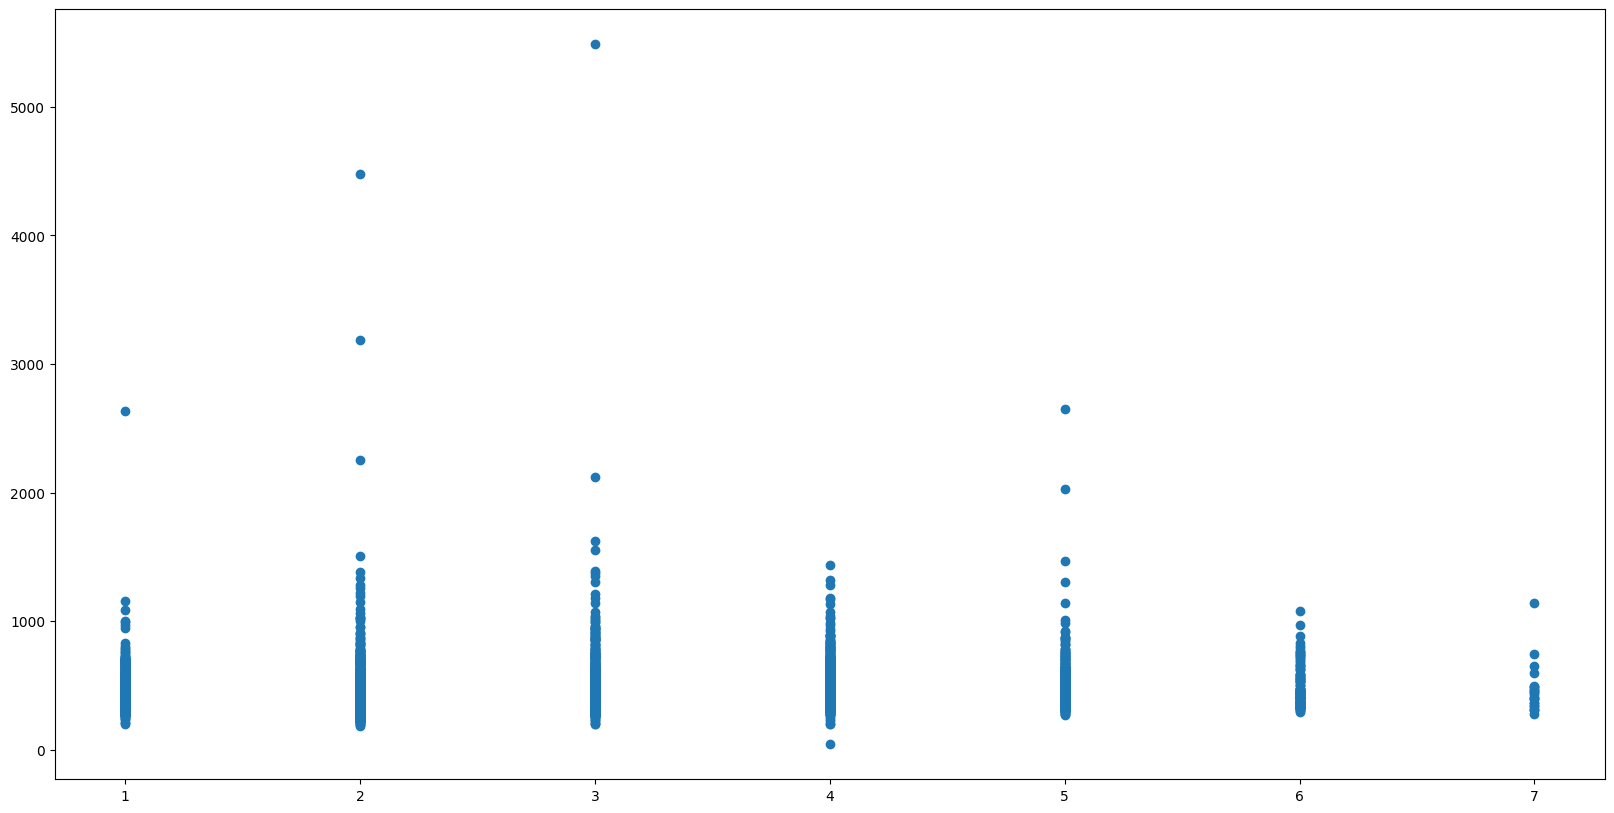

In [18]:
# Create a scatterplot for price_per_sqft vs. beds
x = df['Beds']
y = df['price_per_sqft']

plt.scatter(x, y)
plt.show()

In [19]:
# Inspect for the max value of bed = 3
df_bed3 = df[df['Beds'] == 3]
max_df_bed3 = df_bed3['price_per_sqft'].sort_values(ascending = False)
max_df_bed3

3254    5485.232068
2799    2120.890774
770     1623.364908
3348    1553.829079
3149    1390.268123
           ...     
2781     233.064516
3232     224.299065
1990     206.188341
45       200.702811
2326     198.218263
Name: price_per_sqft, Length: 814, dtype: float64

In [20]:
# Delete the outlier
bed3_outlier = df[(df['price_per_sqft'] == 5485.232068) & (df['Beds'] == 3)].index
df.drop(bed3_outlier, inplace = True)
df.shape

(3335, 6)

In [21]:
# Numerize the place in the dataset using dummies
dummies = pd.get_dummies(df.Place)
dummies.head()

# Concat dummies to the main dataset
# df = pd.concat([df, dummies], axis = 'columns')
df = df.drop('Place', axis = 'columns')
df

,Price,Beds,Bath,Sq.Ft,price_per_sqft
0,979999,4,3.5,1813,540.539989
1,439900,2,2.0,1029,427.502430
2,950000,4,2.5,2545,373.280943
3,280000,2,2.0,898,311.804009
4,649000,2,2.0,1482,437.921727
...,...,...,...,...,...
3354,429900,3,2.0,1275,337.176471
3355,799000,3,2.0,869,919.447641
3357,595000,3,2.5,1733,343.335257
3358,7988000,2,2.5,3544,2253.950339


In [22]:
# Build the model
X = df.drop('Price', axis = 'columns')
X.head()

,Beds,Bath,Sq.Ft,price_per_sqft
0,4,3.5,1813,540.539989
1,2,2.0,1029,427.502430
2,4,2.5,2545,373.280943
3,2,2.0,898,311.804009
4,2,2.0,1482,437.921727


In [23]:
y = df.Price
y.head()

0    979999
1    439900
2    950000
3    280000
4    649000
Name: Price, dtype: int64

In [24]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
model_clf = LinearRegression()
model_clf.fit(X_train, y_train)
model_clf.score(X_test, y_test)

0.6674481400251879

In [25]:
# Shuffle Split for Cross Validation --> equal distribution for the data sample
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 12)
cross_val_score(LinearRegression(), X, y, cv = cv)

array([0.79021826, 0.71200041, 0.77487895, 0.79548422, 0.8078952 ])

In [54]:
# Do GridSearch to look for best estimators, among linear-regresion, lasso, and decision-tree
def find_best_estimators(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params':{
                'copy_X' : [True, False],
                'fit_intercept' : [True, False],
                'n_jobs' : [1,2,3],
                'positive' : [True, False]
            }
        }, 
        'lasso': {
            'model': Lasso(), 
            'params': {
                'alpha': [1, 2], 
                'selection': ['random', 'cyclic']
            }
        }, 
        'decision_tree': {
            'model': DecisionTreeRegressor(), 
            'params': {
                'criterion': ['mse', 'friedman_mse'], 
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score = False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name, 
            'best_score': gs.best_score_, 
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

In [55]:
# Using the function to find the best estimator
find_best_estimators(X, y)

C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\base.py", line 666, in _val

,model,best_score,best_params
0,linear_regression,0.338375,"{'copy_X': True, 'fit_intercept': False, 'n_jo..."
1,lasso,-0.247244,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.876927,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [59]:
# Rebuild the model using DecisionTreeRegressor
best_model = DecisionTreeRegressor()
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.9126958619801195

In [60]:
# Best estimator is the decision tree
# Function to apply the model to find the price
def predict_price(beds, baths, sqft):
    x = np.zeros(len(X.columns))
    x[0] = beds
    x[1] = baths
    x[2] = sqft

    return best_model.predict([x])[0]

In [61]:
# Predict housing price
predicted_price = predict_price(4, 2, 1000)

# Print out the value
print('Price prediction for 4 beds, 2 baths, 1000 sqft is $', predicted_price, ' in Canada in 20

C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


199900.0